# HWK1

## You are expected to characterize data taken from TESS of star TOI 216.

we will be using the data from 

## 1. Available data

You


## 2. New data

You will be accessing data from the MAST repository

In [1]:
# Make sure you have these dependencies available
import lightkurve as lk
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## 1. We first download data on TESSCut FFI Cutouts

For this tutorial we will use the TESS images from sector 1. We will request the 
cutout of a star that has been found to have two orbiting planets. The size of each
stamp is 50x50 in this case.

We data being downloaded is first download the FFI data. This is done by providing the target (a name or angle position), and a sector. Notice that if you don't know the sector you can leave that blank. 


In [2]:
target = 'TOI216'  # TOI 216 Star
tpf = lk.search_tesscut(target, sector=1).download(cutout_size=(50, 50))

In [3]:
# These TESS cut objects provide tons of capabilities. In particular, one can see the
# animation of such data...
tpf.animate()

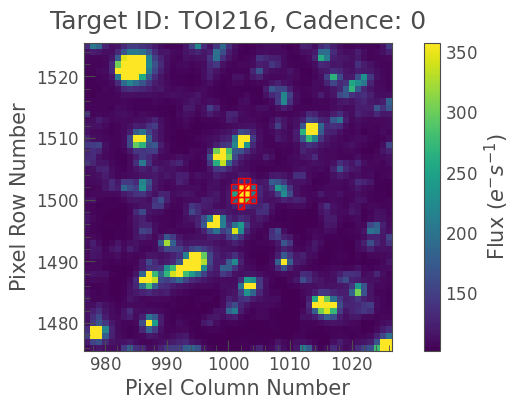

In [4]:
# Now we must create a mask for that star. This is the
aper = tpf.create_threshold_mask()
# And see what it looks like
tpf.plot(aperture_mask=aper);

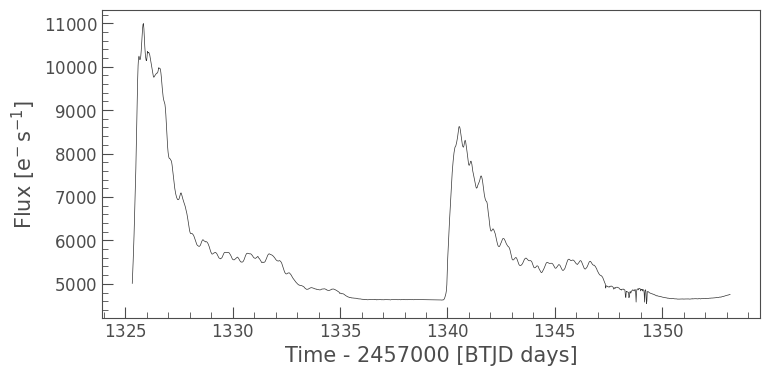

In [5]:
# Now we sum all those pixels
uncorrected_lc = tpf.to_lightcurve(aperture_mask=aper)
uncorrected_lc.plot();

This is clearly the effect of scattered light from the Moon or the Earth on our lightcurve.

In order to remove that effect we can try and correct using the values of the pixels that are not associated with our aperture.

There are these many pixels 2485 in back, and 1267 times 


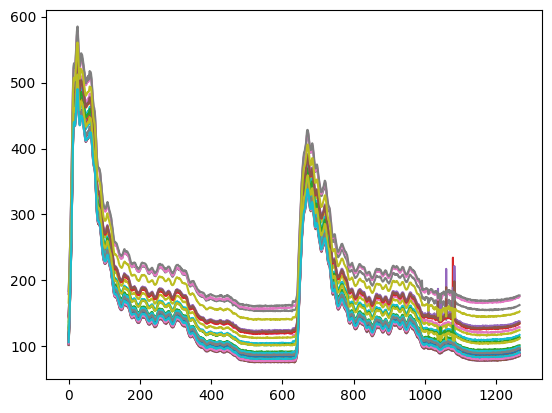

In [6]:
back = tpf.flux[:, ~aper]
ntimes,npix=back.shape
print('There are these many pixels %d in back, and %d times '%(npix, ntimes))
# Now we plot the first 30 lightcurves
fig=plt.figure()
plt.plot(back[:, :30]);

In [7]:
# back is of type Quantity, in order to use, let's try
# and compute the median of these
trend = np.median(back, axis=1)

In [8]:
trend.value

array([110.968   , 126.14002 , 144.33849 , ...,  92.74178 ,  92.968704,
        93.08097 ], dtype=float32)

[]

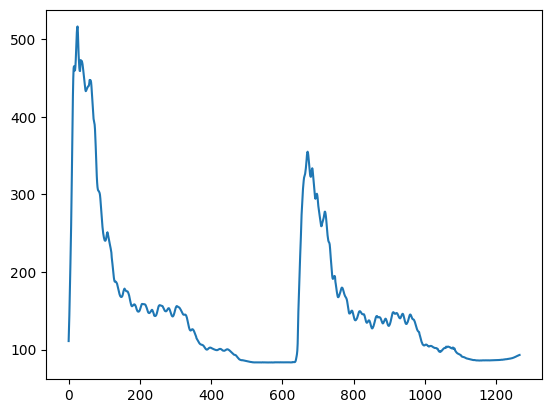

In [9]:
fig = plt.figure()
plt.plot(trend.value)
plt.plot()

In [10]:
# from the uncorrected_lc (sum of all values in aperture pixels)
# we subtract the number of pixels (aper.sum()) times the trend we just computed
median_subtracted_lc = uncorrected_lc - aper.sum()*trend

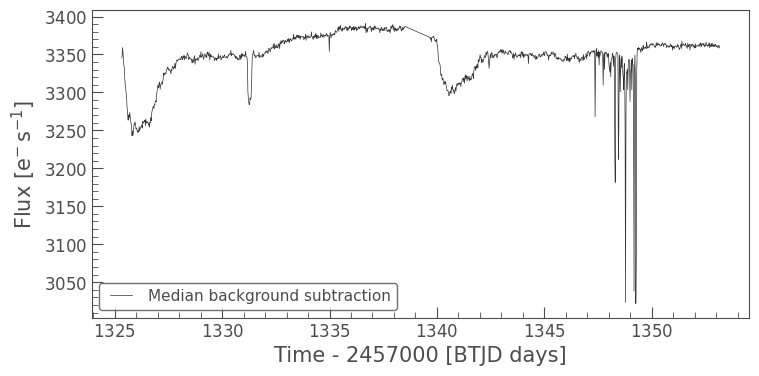

In [11]:
ax = median_subtracted_lc.plot(label='Median background subtraction')

## 2. Now we consider TESS' 2 minute cadence

In each TESS field a number of stars were designated as TESS Object of Interest, or TOI. Photometry from these were computed every 2 minutes and saved as a lightcurve, besides the Full Frame Images (FFI) that you accessed in part 1.

In [12]:
# Download a 2-minute cadence Target Pixel File (TPF)
tpf_2min = lk.search_targetpixelfile(target, mission='TESS', sector=1).download()

/Users/cfuentes/anaconda3/lib/python3.11/site-packages/lightkurve/search.py:423: LightkurveWarning: Warning: 2 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


In [13]:
# Use the pipeline aperture and an uncorrected light curve
# The aperture has already been computed and the lightcurve has been detrended
aper = tpf_2min.pipeline_mask
twomin_lc = tpf_2min.to_lightcurve()

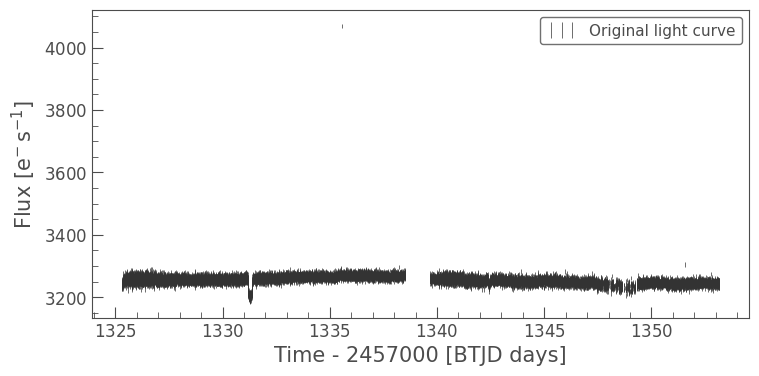

In [14]:
%matplotlib inline
ax = twomin_lc.errorbar(label='Original light curve')

In [15]:


def flux_at_time(t, F, Rp, Rs, c, t_ingress, t_duration, Period):
    """
    Calculate the flux at a given time during the transit.
    Parameters:
    - t: current time
    - F: flux from the star out of transit
    - Rp: radius of the planet
    - Rs: radius of the star
    - c: linear limb-darkening coefficient
    - t_ingress: time of ingress
    - t_duration: full duration of the transit
    Returns:
    - F_t: flux at time t
    """
    t_med = t_ingress+t_duration/2.
    r = Rs*2*(t-t_med)/t_duration
    lambda_val = np.sqrt((Rs**2-r**2)/Rs**2)
    
    depth = (Rp / Rs)**2 * (1 + c * lambda_val)
    delta_F = F * depth
    t_egress = t_ingress + t_duration
    if t < t_ingress or t > t_egress:
        return F
    else:
        return F - delta_F



/var/folders/c_/djjlvx991jz1m2pr1d6gn8400000gn/T/ipykernel_88401/3597918070.py:17: RuntimeWarning: invalid value encountered in sqrt
  lambda_val = np.sqrt((Rs**2-r**2)/Rs**2)


<IPython.core.display.Javascript object>


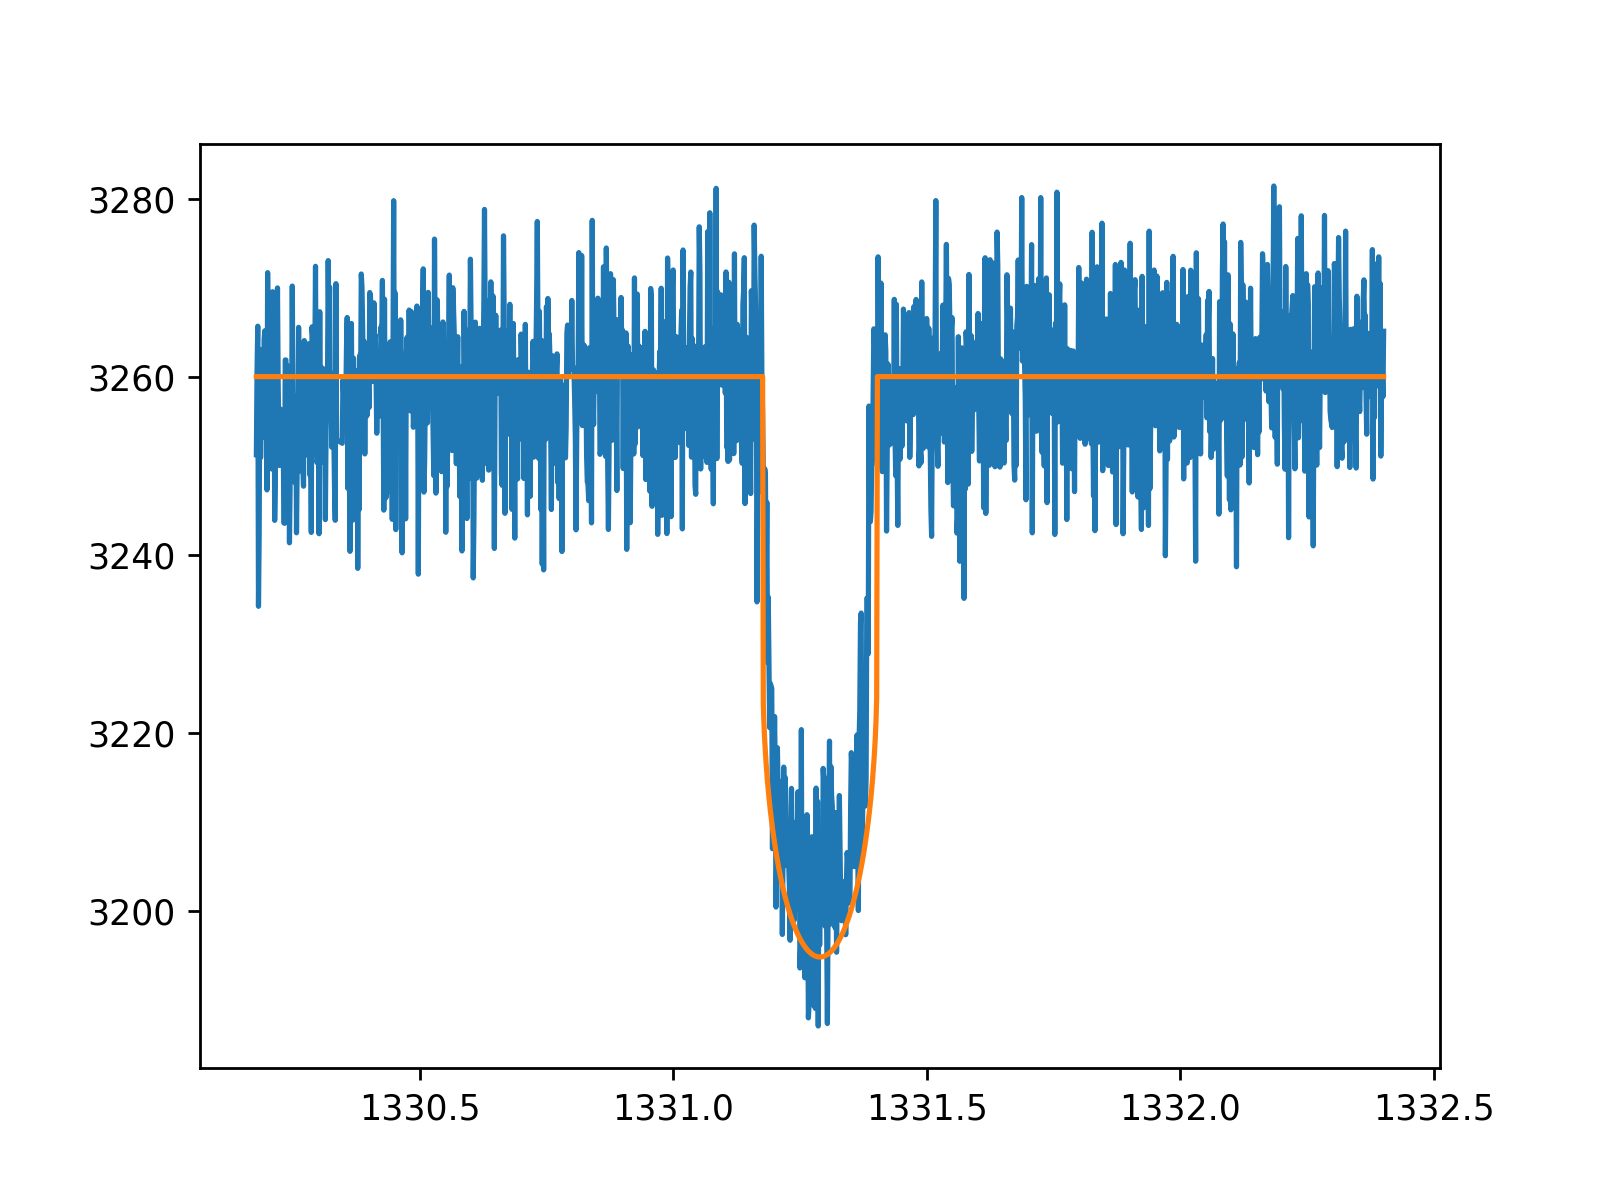

In [16]:
%matplotlib notebook
F, Rp, Rs, c, t_ingress, t_duration, Period = 3260, .1, 1, 1, 1331.177, 0.2252, 10
mod = [flux_at_time(t,F, Rp, Rs, c, t_ingress, t_duration, Period) for t in twomin_lc['time'].btjd]

fig = plt.figure()
filt = (twomin_lc['time'].btjd>t_ingress-1.) * (twomin_lc['time'].btjd<t_ingress+t_duration+1.)
plt.plot(twomin_lc['time'].btjd[filt], twomin_lc['flux'][filt])
plt.plot(twomin_lc['time'].btjd[filt], np.array(mod)[filt])


# Now you are expected to generate fake TESS data based on its statistical properties

## most of this taken from https://spacetelescope.github.io/mast_notebooks/notebooks/astrocut/making_tess_cubes_and_cutouts/making_tess_cubes_and_cutouts.html

In [18]:
%matplotlib inline

import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np

from astrocut import CubeFactory, TicaCubeFactory, CutoutFactory
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astroquery.mast import Observations
from matplotlib.path import Path
from matplotlib.patches import PathPatch

In [19]:
# We will pass in the coordinates as a Sky Coord object
coordinates = SkyCoord(289.0979, -29.3370, unit="deg")

obs = Observations.query_criteria(coordinates=coordinates,
                                  target_name='TICA FFI',
                                  dataproduct_type='image',
                                  sequence_number=27)

obs

<Table masked=True length=1>
intentType obs_collection provenance_name instrument_name project filters wavelength_region target_name target_classification           obs_id          ... jpegURL dataURL dataRights mtFlag  srcDen  obsid     objID     objID1  distance
   str7         str4            str4           str10        str4    str4         str7           str8             str1                   str25           ...   str1    str1     str6     bool  float64   str8      str9      str9   float64 
---------- -------------- --------------- --------------- ------- ------- ----------------- ----------- --------------------- ------------------------- ... ------- ------- ---------- ------ ------- -------- --------- --------- --------
   science           HLSP            TICA      Photometer    TESS    TESS           Optical    TICA FFI                    -- hlsp_tica_s0027-cam1-ccd4 ...      --      --     PUBLIC  False     nan 96814766 185636258 185636258      0.0

<IPython.core.display.Javascript object>


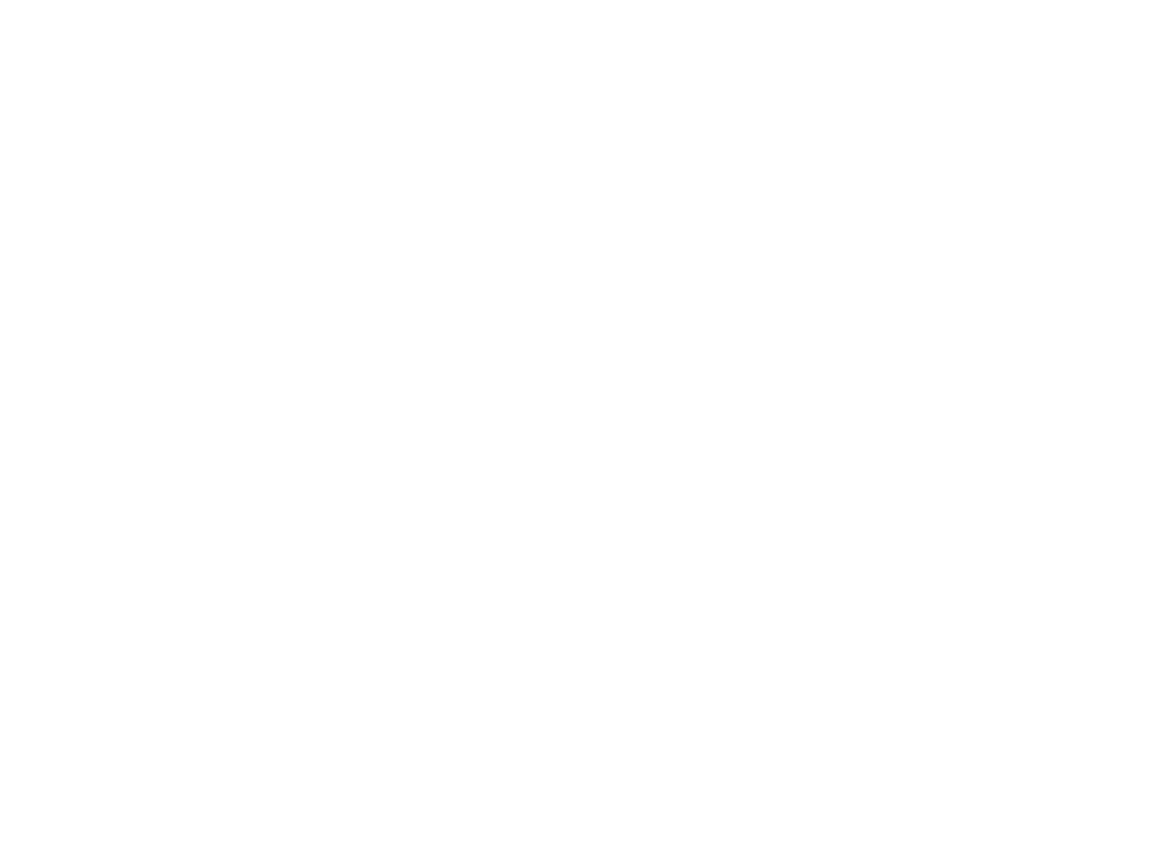

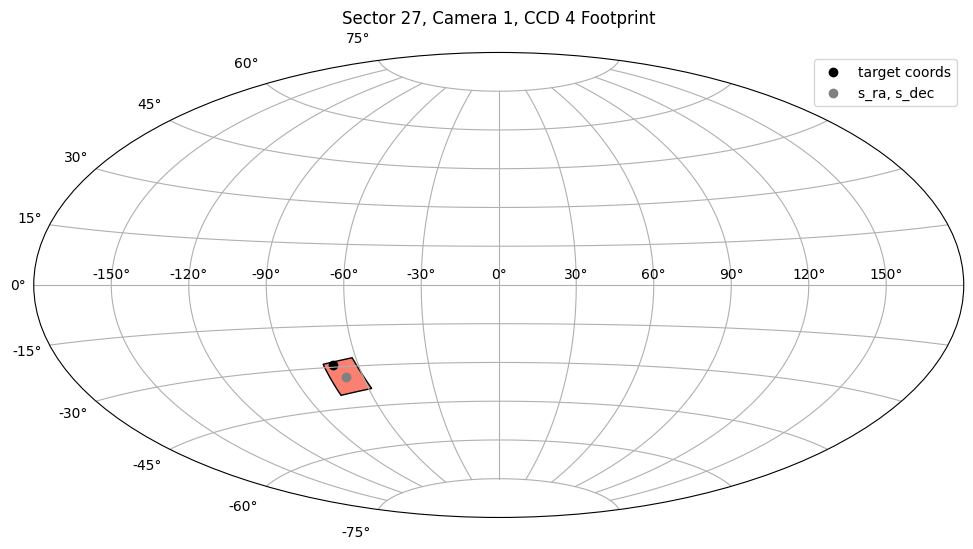

In [21]:
def convert_coords(ra, dec):
    """ Wrap the input coordinates `ra` and `dec` around the upper limit of 180
    degrees and convert to radians so that they may be plotted on the Aitoff canvas.
    
    Parameter(s)
    -----------
    ra : str, int, or float
        The Right Ascension your target lands on, in degrees. May be any object type that 
        can be converted to a float, such as a string, or integer.
    dec : str, int, or float
        The Declination your target lands on, in degrees. May be any object type that 
        can be converted to a float, such as a string, or integer.
        
    Returns
    -------
    ra_rad : float
        The Right Ascension of your target in radians.
    dec_rad : float
        The Declination of your target in radians.
    """

    # Make a SkyCoord object out of the RA, Dec
    c = SkyCoord(ra=float(ra)*u.degree, dec=float(dec)*u.degree, frame='icrs')

    # The plotting only works when the coordinates are in radians.
    # And because it's an aitoff projection, we can't 
    # go beyond 180 degrees, so let's wrap the RA vals around that upper limit.
    ra_rad = c.ra.wrap_at(180 * u.deg).radian
    dec_rad = c.dec.radian

    return ra_rad, dec_rad

def plot_footprint(coords):
    """ Plots a polygon of 4 vertices onto an aitoff projection on a matplotlib canvas.
    
    Parameter(s)
    -----------
    coords : list or array of tuples
        An iterable object (can be a list or array) of 5 tuples, each tuple containing the 
        RA and Dec (float objects) of a vertice of your footprint. There MUST be 5: 1 for each
        vertice, and 1 to return to the starting point, as PathPatch works with a set of drawing 
        instructions, rather than a predetermined shape.
        
    Returns
    -------
    ax : Matplotlib.pyplot figure object subplot
        The subplot that contains the aitoff projection and footprint drawing.
    """
    
    assert len(coords) == 5, 'We need 5 sets of coordinates. 1 for each vertice + 1 to return to the starting point.'
    instructions = [Path.MOVETO, Path.LINETO, Path.LINETO, Path.LINETO, Path.CLOSEPOLY]
    
    # Create the path patch using the `coords` list of tuples and the
    # instructions from above
    c = np.array(coords)
    path = Path(c, instructions)
    ppatch = PathPatch(path, edgecolor='k', facecolor='salmon')

    # Create a matplotlib canvas
    fig = plt.figure(figsize=(12,12))
    
    # We will be using the `aitoff` projection for a globe canvas
    ax = plt.subplot(111, projection='aitoff')
    
    # Need grids!
    ax.grid()
    
    # Add the patch to your canvas
    ax.add_patch(ppatch)
    
    return ax

# Extract the polygon vertices, then store them in separate lists
polygon = obs['s_region'][0]
split = polygon.split(' ')
# Removing the "POLYGON" string
split.pop(0)
# Storing the RAs and Decs separately
ras, decs = split[::2], split[1::2]

# Now we convert our RAs/Decs into radians and wrap them around 180 degrees
coords = []
for ra, dec in zip(ras, decs):
    ra_rad, dec_rad = convert_coords(ra, dec)
    coords.append((ra_rad, dec_rad))

# We use Matplotlib's Path and PathPatch to plot the footprint of sector 27, camera 1, CCD 4
ax = plot_footprint(coords)

# Now let's plot our input target's RA, Dec on top of the footprint to see its relative position
target_ra, target_dec = coordinates.ra.degree, coordinates.dec.degree
target_coords = convert_coords(target_ra, target_dec)
ax.scatter(target_coords[0], target_coords[1], color='k', label='target coords')

# And lastly, let's plot the s_ra and s_dec coordinates to see what they represent
s_coords = convert_coords(obs['s_ra'][0], obs['s_dec'][0])
ax.scatter(s_coords[0], s_coords[1], color='grey', label='s_ra, s_dec')

ax.set_title('Sector 27, Camera 1, CCD 4 Footprint' + '\n' + ' ')
plt.legend()
plt.show()

In [22]:
products = Observations.get_product_list(obs)
products

<Table masked=True length=3360>
 obsID   obs_collection dataproduct_type                            obs_id                           description type ... proposal_id                         productFilename                            size   parent_obsid dataRights calib_level
  str8        str4            str5                                  str59                                str4    str1 ...     str3                                 str64                                int64       str8        str6       int64   
-------- -------------- ---------------- ----------------------------------------------------------- ----------- ---- ... ----------- ---------------------------------------------------------------- -------- ------------ ---------- -----------
96582243           HLSP            image hlsp_tica_tess_ffi_s0027-o1-00117679-cam1-ccd4_tess_v01_img        FITS    D ...         N/A hlsp_tica_tess_ffi_s0027-o1-00117679-cam1-ccd4_tess_v01_img.fits 17795520     96814766     PUBLIC           4
96582244           HLSP            image hlsp_tica_tess_ffi_s0027-o1-00118095-cam1-ccd4_tess_v01_img        FITS    D ...         N/A hlsp_tica_tess_ffi_s0027-o1-00118095-cam1-ccd4_tess_v01_img.fits 17795520     96814766     PUBLIC           4
96582245           HLSP            image hlsp_tica_tess_ffi_s0027-o1-00117909-cam1-ccd4_tess_v01_img        FITS    D ...         N/A hlsp_tica_tess_ffi_s0027-o1-00117909-cam1-ccd4_tess_v01_img.fits 17795520     96814766     PUBLIC           4
96582255           HLSP            image hlsp_tica_tess_ffi_s0027-o1-00117591-cam1-ccd4_tess_v01_img        FITS    D ...         N/A hlsp_tica_tess_ffi_s0027-o1-00117591-cam1-ccd4_tess_v01_img.fits 17795520     96814766     PUBLIC           4
96582257           HLSP            image hlsp_tica_tess_ffi_s0027-o1-00117836-cam1-ccd4_tess_v01_img        FITS    D ...         N/A hlsp_tica_tess_ffi_s0027-o1-00117836-cam1-ccd4_tess_v01_img.fits 17795520     96814766     PUBLIC           4
96582258           HLSP            image hlsp_tica_tess_ffi_s0027-o1-00118089-cam1-ccd4_tess_v01_img        FITS    D ...         N/A hlsp_tica_tess_ffi_s0027-o1-00118089-cam1-ccd4_tess_v01_img.fits 17795520     96814766     PUBLIC           4
96582259           HLSP            image hlsp_tica_tess_ffi_s0027-o1-00117485-cam1-ccd4_tess_v01_img        FITS    D ...         N/A hlsp_tica_tess_ffi_s0027-o1-00117485-cam1-ccd4_tess_v01_img.fits 17795520     96814766     PUBLIC           4
96582260           HLSP            image hlsp_tica_tess_ffi_s0027-o1-00116470-cam1-ccd4_tess_v01_img        FITS    D ...         N/A hlsp_tica_tess_ffi_s0027-o1-00116470-cam1-ccd4_tess_v01_img.fits 17795520     96814766     PUBLIC           4
96582282           HLSP            image hlsp_tica_tess_ffi_s0027-o1-00117827-cam1-ccd4_tess_v01_img        FITS    D ...         N/A hlsp_tica_tess_ffi_s0027-o1-00117827-cam1-ccd4_tess_v01_img.fits 17795520     96814766     PUBLIC           4
96582284           HLSP            image hlsp_tica_tess_ffi_s0027-o1-00117072-cam1-ccd4_tess_v01_img        FITS    D ...         N/A hlsp_tica_tess_ffi_s0027-o1-00117072-cam1-ccd4_tess_v01_img.fits 17795520     96814766     PUBLIC           4
96582285           HLSP            image hlsp_tica_tess_ffi_s0027-o1-00116603-cam1-ccd4_tess_v01_img        FITS    D ...         N/A hlsp_tica_tess_ffi_s0027-o1-00116603-cam1-ccd4_tess_v01_img.fits 17795520     96814766     PUBLIC           4
96582286           HLSP            image hlsp_tica_tess_ffi_s0027-o1-00118086-cam1-ccd4_tess_v01_img        FITS    D ...         N/A hlsp_tica_tess_ffi_s0027-o1-00118086-cam1-ccd4_tess_v01_img.fits 17795520     96814766     PUBLIC           4
96582295           HLSP            image hlsp_tica_tess_ffi_s0027-o1-00117292-cam1-ccd4_tess_v01_img        FITS    D ...         N/A hlsp_tica_tess_ffi_s0027-o1-00117292-cam1-ccd4_tess_v01_img.fits 17795520     96814766     PUBLIC           4
96582296           HLSP            image hlsp_tica_tess_ffi_s002

In [23]:
manifest = Observations.download_products(products[:5], curl_flag=False)
manifest

<Table length=5>
                                                                   Local Path                                                                     Status  Message  URL  
                                                                     str144                                                                        str8    object object
------------------------------------------------------------------------------------------------------------------------------------------------ -------- ------- ------
./mastDownload/HLSP/hlsp_tica_tess_ffi_s0027-o1-00117679-cam1-ccd4_tess_v01_img/hlsp_tica_tess_ffi_s0027-o1-00117679-cam1-ccd4_tess_v01_img.fits COMPLETE    None   None
./mastDownload/HLSP/hlsp_tica_tess_ffi_s0027-o1-00118095-cam1-ccd4_tess_v01_img/hlsp_tica_tess_ffi_s0027-o1-00118095-cam1-ccd4_tess_v01_img.fits COMPLETE    None   None
./mastDownload/HLSP/hlsp_tica_tess_ffi_s0027-o1-00117909-cam1-ccd4_tess_v01_img/hlsp_tica_tess_ffi_s0027-o1-00117909-cam1-ccd4_tess_v01_img.fits COMPLETE    None   None
./mastDownload/HLSP/hlsp_tica_tess_ffi_s0027-o1-00117591-cam1-ccd4_tess_v01_img/hlsp_tica_tess_ffi_s0027-o1-00117591-cam1-ccd4_tess_v01_img.fits COMPLETE    None   None
./mastDownload/HLSP/hlsp_tica_tess_ffi_s0027-o1-00117836-cam1-ccd4_tess_v01_img/hlsp_tica_tess_ffi_s0027-o1-00117836-cam1-ccd4_tess_v01_img.fits COMPLETE    None   None

In [28]:
ffi = manifest['Local Path'][0]
print('FFI')
print(ffi)
print(' ')
print('HDU List')
print(fits.info(ffi))

header = fits.getheader(ffi, 0)
header

FFI
./mastDownload/HLSP/hlsp_tica_tess_ffi_s0027-o1-00117679-cam1-ccd4_tess_v01_img/hlsp_tica_tess_ffi_s0027-o1-00117679-cam1-ccd4_tess_v01_img.fits
 
HDU List
Filename: ./mastDownload/HLSP/hlsp_tica_tess_ffi_s0027-o1-00117679-cam1-ccd4_tess_v01_img/hlsp_tica_tess_ffi_s0027-o1-00117679-cam1-ccd4_tess_v01_img.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     181   (2136, 2078)   float32   
  1                1 BinTableHDU     20   989R x 4C   [K, E, E, I]   
None


SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -32 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 2136                                                  
NAXIS2  =                 2078                                                  
EXTEND  =                    T                                                  
CRM_N   =                   10 / Window for CRM min/max rejection               
ORBIT_ID=                   61 / Orbit ID, not a physical orbit                 
ACS_MODE= 'FP      '           / Attitude Control System mode                   
SC_RA   =    326.8525352094406 / Predicted RA                                   
SC_DEC  =   -72.42645616046441 / Predicted Dec                                  
SC_ROLL =   -145.4939246174957 / Predicted roll                                 
SC_QUATX=           0.550150

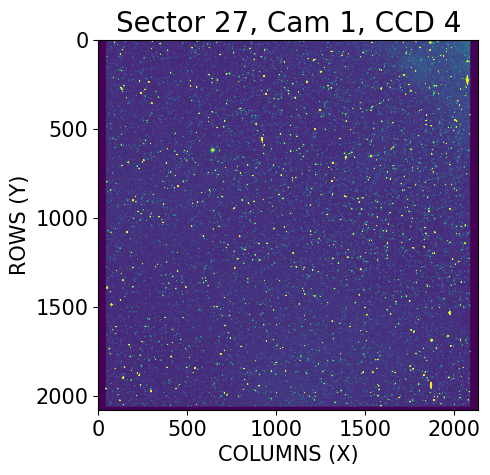

In [57]:


# Retrieve the data and some header metadata for labeling
data = fits.getdata(ffi, 0)
cam, ccd = header['CAMNUM'], header['CCDNUM']

# Plotting
plt.imshow(data, vmin=0, vmax=1000000)

# Labeling
plt.title(f'Sector 27, Cam {cam}, CCD {ccd}', fontsize=20)
plt.xlabel('COLUMNS (X)', fontsize=15)
plt.ylabel('ROWS (Y)', fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=15)

plt.show()

In [36]:
tica_cube_maker = TicaCubeFactory()

In [37]:
cube = tica_cube_maker.make_cube(manifest['Local Path'])

Using hlsp_tica_tess_ffi_s0027-o1-00117679-cam1-ccd4_tess_v01_img.fits to initialize the image header table.
Cube will be made in 1 blocks of 2079 rows each.
Completed file 0 in 0.0584 sec.
Completed file 1 in 0.0154 sec.
Completed file 2 in 0.032 sec.
Completed file 3 in 0.0332 sec.


/Users/cfuentes/anaconda3/lib/python3.11/site-packages/astrocut/make_cube.py:621: StringTruncateWarning: truncated right side string(s) longer than 8 character(s) during assignment
  self.info_table[kwd][i] = ffi_data[0].header.get(kwd, nulval)
/Users/cfuentes/anaconda3/lib/python3.11/site-packages/astrocut/make_cube.py:621: StringTruncateWarning: truncated right side string(s) longer than 8 character(s) during assignment
  self.info_table[kwd][i] = ffi_data[0].header.get(kwd, nulval)
/Users/cfuentes/anaconda3/lib/python3.11/site-packages/astrocut/make_cube.py:621: StringTruncateWarning: truncated right side string(s) longer than 8 character(s) during assignment
  self.info_table[kwd][i] = ffi_data[0].header.get(kwd, nulval)
/Users/cfuentes/anaconda3/lib/python3.11/site-packages/astrocut/make_cube.py:621: StringTruncateWarning: truncated right side string(s) longer than 8 character(s) during assignment
  self.info_table[kwd][i] = ffi_data[0].header.get(kwd, nulval)


Completed file 4 in 0.0388 sec.
Completed block 1 of 1
Total time elapsed: 0.01 min


In [38]:
fits.info(cube)

Filename: img-cube.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     182   ()      
  1                1 ImageHDU         9   (1, 5, 2136, 2078)   float32   
  2                1 BinTableHDU    550   5R x 182C   [J, J, J, J, J, J, J, J, 2A, D, D, D, D, D, D, D, D, D, D, D, D, J, J, J, J, J, J, J, D, J, J, J, J, 16A, D, D, D, D, 9A, 5A, D, 15A, 4A, 4A, D, D, D, D, D, D, D, D, 12A, 12A, D, D, D, D, J, J, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, J, J, J, 16A, 8A, 49A, 64A]   


In [40]:
# This cell will give an error if you uncomment the lines below!

#spoc_cube_maker = CubeFactory()
#spoc_cube_maker.make_cube(manifest['Local Path'])

In [41]:
f = fits.open(cube)

In [42]:
f

[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x318969fd0>, <astropy.io.fits.hdu.image.ImageHDU object at 0x318aa5fd0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x318aad910>]

In [50]:
np.shape(f[1].data)

(2078, 2136, 5, 1)

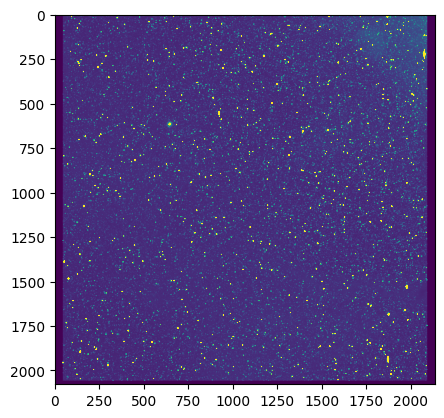

In [61]:
b = np.transpose(f[1].data, (2, 0, 1, 3))

plt.imshow(b[0], vmin=0, vmax=1000000)


In [65]:
np.histogram(b[0].flatten(), bins=100)

(array([4378485,   37260,    9127,    4031,    2257,    1421,    1033,
            710,     574,     458,     338,     255,     201,     172,
            164,     158,     116,     120,     118,      77,      78,
             59,      60,      47,      50,      46,      43,      40,
             37,      24,      36,      22,      22,      22,      22,
             20,      24,      15,      14,      16,      13,      15,
             25,      11,      14,      15,      17,      13,      18,
             15,      10,      16,      15,       6,       9,       9,
              4,       6,       6,       8,       7,       6,       5,
              2,       7,       4,      10,       4,      13,      11,
              3,      11,       5,       7,       6,       6,      10,
             20,      13,      15,      25,      28,      29,      40,
             32,      17,      16,      41,      35,      38,       7,
              3,      11,      16,      37,      26,      17,       2,
      